# Задание 1.2 - Линейный классификатор (Linear classifier)

В этом задании мы реализуем другую модель машинного обучения - линейный классификатор. Линейный классификатор подбирает для каждого класса веса, на которые нужно умножить значение каждого признака и потом сложить вместе.
Тот класс, у которого эта сумма больше, и является предсказанием модели.

В этом задании вы:
- потренируетесь считать градиенты различных многомерных функций
- реализуете подсчет градиентов через линейную модель и функцию потерь softmax
- реализуете процесс тренировки линейного классификатора
- подберете параметры тренировки на практике

На всякий случай, еще раз ссылка на туториал по numpy:  
http://cs231n.github.io/python-numpy-tutorial/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_gradient
from metrics import multiclass_accuracy 
import linear_classifer

# Как всегда, первым делом загружаем данные

Мы будем использовать все тот же SVHN.

In [3]:
def prepare_for_linear_classifier(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    # Add another channel with ones as a bias term
    train_flat_with_ones = np.hstack([train_flat, np.ones((train_X.shape[0], 1))])
    test_flat_with_ones = np.hstack([test_flat, np.ones((test_X.shape[0], 1))])    
    return train_flat_with_ones, test_flat_with_ones
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_linear_classifier(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Играемся с градиентами!

В этом курсе мы будем писать много функций, которые вычисляют градиенты аналитическим методом.

Все функции, в которых мы будем вычислять градиенты, будут написаны по одной и той же схеме.  
Они будут получать на вход точку, где нужно вычислить значение и градиент функции, а на выходе будут выдавать кортеж (tuple) из двух значений - собственно значения функции в этой точке (всегда одно число) и аналитического значения градиента в той же точке (той же размерности, что и вход).
```
def f(x):
    """
    Computes function and analytic gradient at x
    
    x: np array of float, input to the function
    
    Returns:
    value: float, value of the function 
    grad: np array of float, same shape as x
    """
    ...
    
    return value, grad
```

Необходимым инструментом во время реализации кода, вычисляющего градиенты, является функция его проверки. Эта функция вычисляет градиент численным методом и сверяет результат с градиентом, вычисленным аналитическим методом.

Мы начнем с того, чтобы реализовать вычисление численного градиента (numeric gradient) в функции `check_gradient` в `gradient_check.py`. Эта функция будет принимать на вход функции формата, заданного выше, использовать значение `value` для вычисления численного градиента и сравнит его с аналитическим - они должны сходиться.

Напишите часть функции, которая вычисляет градиент с помощью численной производной для каждой координаты. Для вычисления производной используйте так называемую two-point formula (https://en.wikipedia.org/wiki/Numerical_differentiation):

![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/22fc2c0a66c63560a349604f8b6b39221566236d)

Все функции приведенные в следующей клетке должны проходить gradient check.

In [197]:
# TODO: Implement check_gradient function in gradient_check.py

def check_gradient(f, x, delta=1e-5, tol = 1e-4):
    '''
    Checks the implementation of analytical gradient by comparing
    it to numerical gradient using two-point formula

    Arguments:
      f: function that receives x and computes value and gradient
      x: np array, initial point where gradient is checked
      delta: step to compute numerical gradient
      tol: tolerance for comparing numerical and analytical gradient

    Return:
      bool indicating whether gradients match or not
    '''
    
    assert isinstance(x, np.ndarray)
    assert x.dtype == np.float
    
    orig_x = x.copy()
    fx, analytic_grad = f(x)
    assert np.all(np.isclose(orig_x, x, tol)), "Functions shouldn't modify input variables"

    assert analytic_grad.shape == x.shape
    analytic_grad = analytic_grad.copy()

    # We will go through every dimension of x and compute numeric
    # derivative for it
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
        analytic_grad_at_ix = analytic_grad[ix]
        
        x_plus_delta = x.copy()
        x_minus_delta = x.copy()
        x_plus_delta[ix] = x_plus_delta[ix] + delta
        x_minus_delta[ix] = x_minus_delta[ix] - delta
        numeric_grad_at_ix = (f(x_plus_delta)[0] - f(x_minus_delta)[0]) / (2 * delta)
        
        # TODO compute value of numeric gradient of f to idx
        if not np.isclose(numeric_grad_at_ix, analytic_grad_at_ix, tol):
            print("Gradients are different at %s. Analytic: %2.5f, Numeric: %2.5f" % (ix, analytic_grad_at_ix, numeric_grad_at_ix))
            return False
        
        it.iternext()

    print("Gradient check passed!")
    return True

In [198]:
# All the functions below should pass the gradient check

def square(x):
    return float(x*x), 2*x

check_gradient(square, np.array([3.0]))

def array_sum(x):
    assert x.shape == (2,), x.shape
    return np.sum(x), np.ones_like(x)

check_gradient(array_sum, np.array([3.0, 2.0]))

def array_2d_sum(x):
    assert x.shape == (2,2)
    return np.sum(x), np.ones_like(x)

check_gradient(array_2d_sum, np.array([[3.0, 2.0], [1.0, 0.0]]))

Gradient check passed!
Gradient check passed!
Gradient check passed!


True

## Начинаем писать свои функции, считающие аналитический градиент

Теперь реализуем функцию softmax, которая получает на вход оценки для каждого класса и преобразует их в вероятности от 0 до 1:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/e348290cf48ddbb6e9a6ef4e39363568b67c09d3)

**Важно:** Практический аспект вычисления этой функции заключается в том, что в ней учавствует вычисление экспоненты от потенциально очень больших чисел - это может привести к очень большим значениям в числителе и знаменателе за пределами диапазона float.

К счастью, у этой проблемы есть простое решение -- перед вычислением softmax вычесть из всех оценок максимальное значение среди всех оценок:
```
predictions -= np.max(predictions)
```
(подробнее здесь - http://cs231n.github.io/linear-classify/#softmax, секция `Practical issues: Numeric stability`)

In [328]:
np.eye(5)[1]

array([0., 1., 0., 0., 0.])

In [398]:
import numpy as np


def softmax(predictions):
    '''
    Computes probabilities from scores

    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output

    Returns:
      probs, np array of the same shape as predictions - 
        probability for every class, 0..1
    '''
    # TODO implement softmax
    # Your final implementation shouldn't have any loops
    predictions = np.copy(predictions)
    
    kwargs = dict()
    if len(predictions.shape) == 2:
        predictions -= np.max(predictions, axis=1).reshape(-1, 1)
        exps = np.exp(predictions)
        probs = exps / exps.sum(axis=1).reshape(-1, 1)
    else:
        predictions -= np.max(predictions)
        exps = np.exp(predictions)
        probs = exps / exps.sum()
        
    return probs


def cross_entropy_loss(probs, target_index):
    '''
    Computes cross-entropy loss

    Arguments:
      probs, np array, shape is either (N) or (batch_size, N) -
        probabilities for every class
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)

    Returns:
      loss: single value
    '''
    # TODO implement cross-entropy
    # Your final implementation shouldn't have any loops
    if len(probs.shape) == 2:
        n_classes = probs.shape[1]
        one_hot_true_classes = np.eye(n_classes)[np.array(target_index).reshape(-1)]
    else:
        n_classes = probs.shape[0]
        one_hot_true_classes = np.eye(n_classes)[target_index]

    
    loss = -(one_hot_true_classes * np.log(probs)).sum()
        
    return loss


def softmax_with_cross_entropy(predictions, target_index):
    '''
    Computes softmax and cross-entropy loss for model predictions,
    including the gradient

    Arguments:
      predictions, np array, shape is either (N) or (batch_size, N) -
        classifier output
      target_index: np array of int, shape is (1) or (batch_size) -
        index of the true class for given sample(s)

    Returns:
      loss, single value - cross-entropy loss
      dprediction, np array same shape as predictions - gradient of predictions by loss value
    '''
    # TODO implement softmax with cross-entropy
    # Your final implementation shouldn't have any loops
    probs = softmax(predictions)
    loss = cross_entropy_loss(probs, target_index)
    
    if len(probs.shape) == 2:
        n_classes = probs.shape[1]
        one_hot_true_classes = np.eye(n_classes)[np.array(target_index).reshape(-1)]
    else:
        n_classes = probs.shape[0]
        one_hot_true_classes = np.eye(n_classes)[target_index]

    dprediction = probs - one_hot_true_classes  # https://www.youtube.com/watch?v=bZihskzsSjM&t=1090s
    
    return loss, dprediction


def l2_regularization(W, reg_strength):
    '''
    Computes L2 regularization loss on weights and its gradient

    Arguments:
      W, np array - weights
      reg_strength - float value

    Returns:
      loss, single value - l2 regularization loss
      gradient, np.array same shape as W - gradient of weight by l2 loss
    '''

    # TODO: implement l2 regularization and gradient
    # Your final implementation shouldn't have any loops
    loss = reg_strength * np.power(W, 2).sum()
    grad = 2 * reg_strength * W
    return loss, grad
    

def linear_softmax(X, W, target_index):
    '''
    Performs linear classification and returns loss and gradient over W

    Arguments:
      X, np array, shape (num_batch, num_features) - batch of images
      W, np array, shape (num_features, classes) - weights
      target_index, np array, shape (num_batch) - index of target classes

    Returns:
      loss, single value - cross-entropy loss
      gradient, np.array same shape as W - gradient of weight by loss

    '''
    predictions = np.dot(X, W)
    loss, dprediction = softmax_with_cross_entropy(predictions, target_index)
    dW = X.T @ dprediction
    # TODO implement prediction and gradient over W
    # Your final implementation shouldn't have any loops
    
    return loss, dW


class LinearSoftmaxClassifier():
    def __init__(self):
        self.W = None

    def fit(self, X, y, batch_size=100, learning_rate=1e-7, reg=1e-5,
            epochs=1):
        '''
        Trains linear classifier
        
        Arguments:
          X, np array (num_samples, num_features) - training data
          y, np array of int (num_samples) - labels
          batch_size, int - batch size to use
          learning_rate, float - learning rate for gradient descent
          reg, float - L2 regularization strength
          epochs, int - number of epochs
        '''

        num_train = X.shape[0]
        num_features = X.shape[1]
        num_classes = np.max(y)+1
        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        loss_history = []
        for epoch in range(epochs):
            shuffled_indices = np.arange(num_train)
            np.random.shuffle(shuffled_indices)
            sections = np.arange(batch_size, num_train, batch_size)
            batches_indices = np.array_split(shuffled_indices, sections)

            # TODO implement generating batches from indices
            # Compute loss and gradients
            # Apply gradient to weights using learning rate
            # Don't forget to add both cross-entropy loss
            # and regularization!
            loss = 0.
            for batch in batches_indices:
                loss_W, grad_W = linear_softmax(X[batch], self.W, y[batch])
                loss_W_l2, grad_W_l2 = l2_regularization(self.W, reg)
                self.W -= learning_rate * (grad_W + grad_W_l2)
                loss += loss_W_l2
                loss += loss_W
            loss_history.append(loss)
            # end
            print("Epoch %i, loss: %f" % (epoch, loss))

        return loss_history

    def predict(self, X):
        '''
        Produces classifier predictions on the set
       
        Arguments:
          X, np array (test_samples, num_features)

        Returns:
          y_pred, np.array of int (test_samples)
        '''
        y_pred = np.zeros(X.shape[0], dtype=np.int)

        # TODO Implement class prediction
        # Your final implementation shouldn't have any loops
        predictions = np.dot(X, self.W)
        y_pred = np.argmax(softmax(predictions), axis=1)

        return y_pred

In [399]:
# TODO Implement softmax and cross-entropy for single sample
probs = softmax(np.array([-10, 0, 10]))

# Make sure it works for big numbers too!
probs = softmax(np.array([1000, 0, 0]))
assert np.isclose(probs[0], 1.0)

Кроме этого, мы реализуем cross-entropy loss, которую мы будем использовать как функцию ошибки (error function).
В общем виде cross-entropy определена следующим образом:
![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/0cb6da032ab424eefdca0884cd4113fe578f4293)

где x - все классы, p(x) - истинная вероятность принадлежности сэмпла классу x, а q(x) - вероятность принадлежности классу x, предсказанная моделью.  
В нашем случае сэмпл принадлежит только одному классу, индекс которого передается функции. Для него p(x) равна 1, а для остальных классов - 0. 

Это позволяет реализовать функцию проще!

In [400]:
probs = softmax(np.array([-5, 0, 5]))
cross_entropy_loss(probs, 1)

5.006760443547122

После того как мы реализовали сами функции, мы можем реализовать градиент.

Оказывается, что вычисление градиента становится гораздо проще, если объединить эти функции в одну, которая сначала вычисляет вероятности через softmax, а потом использует их для вычисления функции ошибки через cross-entropy loss.

Эта функция `softmax_with_cross_entropy` будет возвращает и значение ошибки, и градиент по входным параметрам. Мы проверим корректность реализации с помощью `check_gradient`.

In [401]:
# TODO Implement combined function or softmax and cross entropy and produces gradient
loss, grad = softmax_with_cross_entropy(np.array([1, 0, 0]), 1)
check_gradient(lambda x: softmax_with_cross_entropy(x, 1), np.array([1, 0, 0], np.float))

Gradient check passed!


True

В качестве метода тренировки мы будем использовать стохастический градиентный спуск (stochastic gradient descent или SGD), который работает с батчами сэмплов. 

Поэтому все наши фукнции будут получать не один пример, а батч, то есть входом будет не вектор из `num_classes` оценок, а матрица размерности `batch_size, num_classes`. Индекс примера в батче всегда будет первым измерением.

Следующий шаг - переписать наши функции так, чтобы они поддерживали батчи.

Финальное значение функции ошибки должно остаться числом, и оно равно среднему значению ошибки среди всех примеров в батче.

In [402]:
# TODO Extend combined function so it can receive a 2d array with batch of samples
np.random.seed(42)
# Test batch_size = 1
num_classes = 4
batch_size = 1
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: softmax_with_cross_entropy(x, target_index), predictions)

# Test batch_size = 3
num_classes = 4
batch_size = 3
predictions = np.random.randint(-1, 3, size=(batch_size, num_classes)).astype(np.float)
target_index = np.random.randint(0, num_classes, size=(batch_size, 1)).astype(np.int)
check_gradient(lambda x: softmax_with_cross_entropy(x, target_index), predictions)

# Make sure maximum subtraction for numberic stability is done separately for every sample in the batch
probs = softmax(np.array([[20,0,0], [1000, 0, 0]]))
assert np.all(np.isclose(probs[:, 0], 1.0))

Gradient check passed!
Gradient check passed!


### Наконец, реализуем сам линейный классификатор!

softmax и cross-entropy получают на вход оценки, которые выдает линейный классификатор.

Он делает это очень просто: для каждого класса есть набор весов, на которые надо умножить пиксели картинки и сложить. Получившееся число и является оценкой класса, идущей на вход softmax.

Таким образом, линейный классификатор можно представить как умножение вектора с пикселями на матрицу W размера `num_features, num_classes`. Такой подход легко расширяется на случай батча векторов с пикселями X размера `batch_size, num_features`:

`predictions = X * W`, где `*` - матричное умножение.

Реализуйте функцию подсчета линейного классификатора и градиентов по весам `linear_softmax` в файле `linear_classifer.py`

In [403]:
# TODO Implement linear_softmax function that uses softmax with cross-entropy for linear classifier
batch_size = 2
num_classes = 2
num_features = 3
np.random.seed(42)
W = np.random.randint(-1, 3, size=(num_features, num_classes)).astype(np.float)
X = np.random.randint(-1, 3, size=(batch_size, num_features)).astype(np.float)
target_index = np.ones(batch_size, dtype=np.int)

loss, dW = linear_softmax(X, W, target_index)
check_gradient(lambda w: linear_softmax(X, w, target_index), W)

Gradient check passed!


True

### И теперь регуляризация

Мы будем использовать L2 regularization для весов как часть общей функции ошибки.

Напомним, L2 regularization определяется как

l2_reg_loss = regularization_strength * sum<sub>ij</sub> W[i, j]<sup>2</sup>

Реализуйте функцию для его вычисления и вычисления соотвествующих градиентов.

In [404]:
# TODO Implement l2_regularization function that implements loss for L2 regularization
l2_regularization(W, 0.01)
check_gradient(lambda w: l2_regularization(w, 0.01), W)

Gradient check passed!


True

# Тренировка!

Градиенты в порядке, реализуем процесс тренировки!

In [416]:
# TODO: Implement LinearSoftmaxClassifier.fit function
classifier = LinearSoftmaxClassifier()
loss_history = classifier.fit(train_X, train_y, epochs=10, learning_rate=1e-4, batch_size=300, reg=1e1)

Epoch 0, loss: 20653.061912
Epoch 1, loss: 20487.736576
Epoch 2, loss: 20354.186673
Epoch 3, loss: 20259.398840
Epoch 4, loss: 20184.480043
Epoch 5, loss: 20141.812324
Epoch 6, loss: 20097.280886
Epoch 7, loss: 20061.933577
Epoch 8, loss: 20042.227651
Epoch 9, loss: 20018.380936


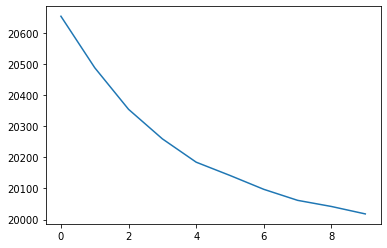

In [417]:
# let's look at the loss history!
plt.plot(loss_history)

In [418]:
# Let's check how it performs on validation set
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy: ", accuracy)

# Now, let's train more and see if it performs better
classifier.fit(train_X, train_y, epochs=100, learning_rate=1e-5, batch_size=300, reg=1e1)
pred = classifier.predict(val_X)
accuracy = multiclass_accuracy(pred, val_y)
print("Accuracy after training for 100 epochs: ", accuracy)

Accuracy:  0.23
Epoch 0, loss: 19985.394438
Epoch 1, loss: 19979.843614
Epoch 2, loss: 19976.813079
Epoch 3, loss: 19975.154714
Epoch 4, loss: 19973.195170
Epoch 5, loss: 19972.567599
Epoch 6, loss: 19971.097281
Epoch 7, loss: 19968.995500
Epoch 8, loss: 19969.295326
Epoch 9, loss: 19967.112184
Epoch 10, loss: 19965.688164
Epoch 11, loss: 19964.706682
Epoch 12, loss: 19963.832044
Epoch 13, loss: 19963.056186
Epoch 14, loss: 19961.611321
Epoch 15, loss: 19960.718776
Epoch 16, loss: 19959.583852
Epoch 17, loss: 19958.564644
Epoch 18, loss: 19957.841296
Epoch 19, loss: 19956.484197
Epoch 20, loss: 19956.506042
Epoch 21, loss: 19954.896441
Epoch 22, loss: 19954.404021
Epoch 23, loss: 19953.218928
Epoch 24, loss: 19951.995318
Epoch 25, loss: 19951.940168
Epoch 26, loss: 19950.568670
Epoch 27, loss: 19949.739932
Epoch 28, loss: 19949.349159
Epoch 29, loss: 19948.649033
Epoch 30, loss: 19947.840497
Epoch 31, loss: 19947.404098
Epoch 32, loss: 19946.033280
Epoch 33, loss: 19945.243037
Epoch 34

### Как и раньше, используем кросс-валидацию для подбора гиперпараметтов.

В этот раз, чтобы тренировка занимала разумное время, мы будем использовать только одно разделение на тренировочные (training) и проверочные (validation) данные.

Теперь нам нужно подобрать не один, а два гиперпараметра! Не ограничивайте себя изначальными значениями в коде.  
Добейтесь точности более чем **20%** на проверочных данных (validation data).

In [420]:
from sklearn.model_selection import train_test_split

num_epochs = 200
batch_size = 300

learning_rates = [1e-3, 1e-4, 1e-5]
reg_strengths = [1e-4, 1e-5, 1e-6]

best_classifier = None
best_val_accuracy = -np.inf

# TODO use validation set to find the best hyperparameters
# hint: for best results, you might need to try more values for learning rate and regularization strength 
# than provided initially
for learning_rate in learning_rates:
    for reg_strength in reg_strengths:
        print(learning_rate, reg_strength)
        classifier.fit(train_X, train_y, epochs=100, learning_rate=learning_rate, batch_size=300, reg=reg_strength)
        pred = classifier.predict(val_X)
        accuracy = multiclass_accuracy(pred, val_y)
        
        if accuracy > best_val_accuracy:
            best_classifier = classifier
            best_val_accuracy = accuracy
            print('New best classifier with accuracy={}'.format(best_val_accuracy))
        print()
        
print('best validation accuracy achieved: %f' % best_val_accuracy)

0.001 0.0001
Epoch 0, loss: 22726.463864
Epoch 1, loss: 23779.930313
Epoch 2, loss: 21666.675840
Epoch 3, loss: 24656.184198
Epoch 4, loss: 22640.439003
Epoch 5, loss: 22503.814588
Epoch 6, loss: 21472.008426
Epoch 7, loss: 22548.327715
Epoch 8, loss: 23171.539922
Epoch 9, loss: 23247.644472
Epoch 10, loss: 21975.956773
Epoch 11, loss: 23826.704886
Epoch 12, loss: 23210.519961
Epoch 13, loss: 23362.861635
Epoch 14, loss: 21586.384343
Epoch 15, loss: 22739.066010
Epoch 16, loss: 24019.131082
Epoch 17, loss: 21035.369668
Epoch 18, loss: 23964.669096
Epoch 19, loss: 22744.617266
Epoch 20, loss: 23881.528421
Epoch 21, loss: 22375.206380
Epoch 22, loss: 22556.745665
Epoch 23, loss: 23252.103705
Epoch 24, loss: 22153.984070
Epoch 25, loss: 22780.590840
Epoch 26, loss: 23858.149114
Epoch 27, loss: 22991.980989
Epoch 28, loss: 23384.710533
Epoch 29, loss: 23265.613822
Epoch 30, loss: 22511.938624
Epoch 31, loss: 22701.332944
Epoch 32, loss: 23765.581547
Epoch 33, loss: 22546.671687
Epoch 34, l

Epoch 80, loss: 20711.567457
Epoch 81, loss: 21327.018104
Epoch 82, loss: 22251.340404
Epoch 83, loss: 21456.920736
Epoch 84, loss: 20890.488010
Epoch 85, loss: 20994.323592
Epoch 86, loss: 20790.647647
Epoch 87, loss: 21086.309116
Epoch 88, loss: 20807.845617
Epoch 89, loss: 21665.160268
Epoch 90, loss: 21580.469778
Epoch 91, loss: 22030.848587
Epoch 92, loss: 21128.090782
Epoch 93, loss: 20936.031369
Epoch 94, loss: 22409.244242
Epoch 95, loss: 20186.915988
Epoch 96, loss: 21909.990367
Epoch 97, loss: 20567.458250
Epoch 98, loss: 20741.838832
Epoch 99, loss: 22029.424343
New best classifier with accuracy=0.201

0.0001 0.0001
Epoch 0, loss: 17678.117899
Epoch 1, loss: 17241.062958
Epoch 2, loss: 17182.776256
Epoch 3, loss: 17138.782529
Epoch 4, loss: 17101.788690
Epoch 5, loss: 17071.326228
Epoch 6, loss: 17043.729390
Epoch 7, loss: 17019.897550
Epoch 8, loss: 17007.390547
Epoch 9, loss: 16993.494253
Epoch 10, loss: 16973.617770
Epoch 11, loss: 16972.836434
Epoch 12, loss: 16964.58149

Epoch 60, loss: 16805.426962
Epoch 61, loss: 16800.925552
Epoch 62, loss: 16800.292354
Epoch 63, loss: 16798.453747
Epoch 64, loss: 16801.380825
Epoch 65, loss: 16802.853194
Epoch 66, loss: 16795.935946
Epoch 67, loss: 16798.281756
Epoch 68, loss: 16801.994862
Epoch 69, loss: 16797.257621
Epoch 70, loss: 16798.151156
Epoch 71, loss: 16796.263920
Epoch 72, loss: 16800.689711
Epoch 73, loss: 16800.985354
Epoch 74, loss: 16794.312422
Epoch 75, loss: 16794.846915
Epoch 76, loss: 16796.791067
Epoch 77, loss: 16797.454908
Epoch 78, loss: 16800.142619
Epoch 79, loss: 16798.731066
Epoch 80, loss: 16797.345541
Epoch 81, loss: 16793.532344
Epoch 82, loss: 16791.958876
Epoch 83, loss: 16792.531045
Epoch 84, loss: 16792.973293
Epoch 85, loss: 16793.867898
Epoch 86, loss: 16794.798382
Epoch 87, loss: 16793.889790
Epoch 88, loss: 16790.703713
Epoch 89, loss: 16797.345245
Epoch 90, loss: 16793.584685
Epoch 91, loss: 16793.732165
Epoch 92, loss: 16789.407156
Epoch 93, loss: 16791.633024
Epoch 94, loss

Epoch 41, loss: 16757.465174
Epoch 42, loss: 16757.496809
Epoch 43, loss: 16757.015550
Epoch 44, loss: 16756.822115
Epoch 45, loss: 16757.087900
Epoch 46, loss: 16756.952546
Epoch 47, loss: 16757.104473
Epoch 48, loss: 16756.954657
Epoch 49, loss: 16756.907112
Epoch 50, loss: 16756.868770
Epoch 51, loss: 16757.239839
Epoch 52, loss: 16756.765988
Epoch 53, loss: 16756.677606
Epoch 54, loss: 16756.841204
Epoch 55, loss: 16756.891479
Epoch 56, loss: 16756.889475
Epoch 57, loss: 16757.225715
Epoch 58, loss: 16756.805564
Epoch 59, loss: 16756.876191
Epoch 60, loss: 16756.587263
Epoch 61, loss: 16756.445147
Epoch 62, loss: 16756.610496
Epoch 63, loss: 16756.551447
Epoch 64, loss: 16756.315257
Epoch 65, loss: 16756.483201
Epoch 66, loss: 16757.184918
Epoch 67, loss: 16756.795333
Epoch 68, loss: 16756.261324
Epoch 69, loss: 16756.510598
Epoch 70, loss: 16756.408188
Epoch 71, loss: 16756.775359
Epoch 72, loss: 16756.615711
Epoch 73, loss: 16756.382258
Epoch 74, loss: 16756.501830
Epoch 75, loss

# Какой же точности мы добились на тестовых данных?

In [421]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Linear softmax classifier test set accuracy: %f' % (test_accuracy, ))

Linear softmax classifier test set accuracy: 0.193000
